# Fiberbits — EDA, Visualization & Logistic Regression (Notebook)

This notebook:
- Loads the attached dataset (`Fiberbits.csv`)
- Performs **EDA** (shape, types, missing values, duplicates, summary stats)
- Creates **visualizations** (target balance, distributions, correlations, feature vs target)
- Builds a **Logistic Regression** model to predict `active_cust` (binary label)

> Dataset path used in this environment: `/mnt/data/Fiberbits.csv`


In [ ]:
# Cell 1 — Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 140)


In [ ]:
# Cell 2 — Load data
csv_path = r"Fiberbits.csv"
df = pd.read_csv(csv_path)

print("Shape:", df.shape)
display(df.head(10))


Shape: (100000, 9)


,active_cust,income,months_on_network,Num_complaints,number_plan_changes,relocated,monthly_bill,technical_issues_per_month,Speed_test_result
0,0,1586,85,4,1,0,121,4,85
1,0,1581,85,4,1,0,133,4,85
2,0,1594,82,4,1,0,118,4,85
3,0,1594,82,4,1,0,123,4,85
4,1,1609,80,4,1,0,177,4,85
5,1,1601,80,4,1,0,31,4,85
6,1,1598,81,4,1,0,126,4,85
7,1,1597,81,4,1,0,30,4,85
8,1,1604,81,4,1,0,49,4,85
9,1,1605,81,4,1,0,35,4,85


## 1) Basic Structure & Data Quality Checks

In [ ]:
# Cell 3 — Column overview, dtypes, and quick stats
display(df.info())
display(df.describe(include="all").T)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype
---  ------                      --------------   -----
 0   active_cust                 100000 non-null  int64
 1   income                      100000 non-null  int64
 2   months_on_network           100000 non-null  int64
 3   Num_complaints              100000 non-null  int64
 4   number_plan_changes         100000 non-null  int64
 5   relocated                   100000 non-null  int64
 6   monthly_bill                100000 non-null  int64
 7   technical_issues_per_month  100000 non-null  int64
 8   Speed_test_result           100000 non-null  int64
dtypes: int64(9)
memory usage: 6.9 MB


None

,count,mean,std,min,25%,50%,75%,max
active_cust,100000.0,0.57859,0.493787,0.0,0.0,1.0,1.0,1.0
income,100000.0,1855.27991,2712.385257,1130.0,1674.0,1805.0,1907.0,229821.0
months_on_network,100000.0,58.40245,18.643736,-20.0,47.0,56.0,70.0,449.0
Num_complaints,100000.0,4.01284,0.285265,3.0,4.0,4.0,4.0,6.0
number_plan_changes,100000.0,1.38541,1.617101,0.0,0.0,1.0,2.0,9.0
relocated,100000.0,0.12348,0.328989,0.0,0.0,0.0,0.0,1.0
monthly_bill,100000.0,95.81645,50.161327,30.0,45.0,87.0,133.0,181.0
technical_issues_per_month,100000.0,3.31673,1.241470,1.0,3.0,4.0,4.0,7.0
Speed_test_result,100000.0,81.66854,9.952554,72.0,78.0,81.0,85.0,332.0


In [ ]:
# Cell 4 — Missing values
missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(df) * 100).round(2)

missing_report = pd.DataFrame({"missing_count": missing, "missing_pct": missing_pct})
display(missing_report)

print("Total missing cells:", int(missing.sum()))


,missing_count,missing_pct
active_cust,0,0.0
income,0,0.0
months_on_network,0,0.0
Num_complaints,0,0.0
number_plan_changes,0,0.0
relocated,0,0.0
monthly_bill,0,0.0
technical_issues_per_month,0,0.0
Speed_test_result,0,0.0


Total missing cells: 0


In [ ]:
# Cell 5 — Duplicate rows
dup_count = df.duplicated().sum()
print("Duplicate rows:", int(dup_count))

if dup_count > 0:
    display(df[df.duplicated()].head(10))


Duplicate rows: 1672


,active_cust,income,months_on_network,Num_complaints,number_plan_changes,relocated,monthly_bill,technical_issues_per_month,Speed_test_result
92,1,1594,82,4,1,0,80,4,85
492,1,1683,69,4,2,0,38,4,86
521,1,1680,69,4,2,0,77,4,86
679,1,1701,66,4,0,0,38,1,86
743,1,1683,69,4,0,0,52,1,87
841,1,1706,67,4,0,0,42,1,86
896,1,1729,63,4,0,0,50,1,86
917,1,1720,64,4,0,0,50,1,86
932,1,1688,68,4,0,0,41,1,86
983,1,1730,63,4,0,0,46,1,86


## 2) Target Variable Check (`active_cust`)

We assume:
- `active_cust = 1` → active customer
- `active_cust = 0` → not active (churn / inactive)

We’ll model `active_cust` as the **binary target**.


,count
active_cust,
0,42141
1,57859


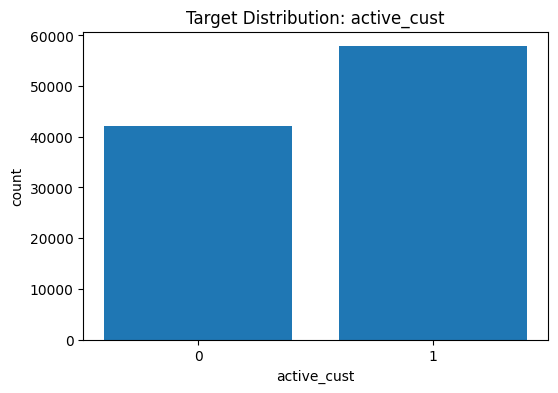

In [ ]:
# Cell 6 — Target distribution
target_col = "active_cust"
vc = df[target_col].value_counts().sort_index()
display(vc.to_frame("count"))

plt.figure(figsize=(6,4))
plt.bar(vc.index.astype(str), vc.values)
plt.title("Target Distribution: active_cust")
plt.xlabel("active_cust")
plt.ylabel("count")
plt.show()


## 3) Univariate Distributions

We’ll look at distributions of numeric features using histograms.


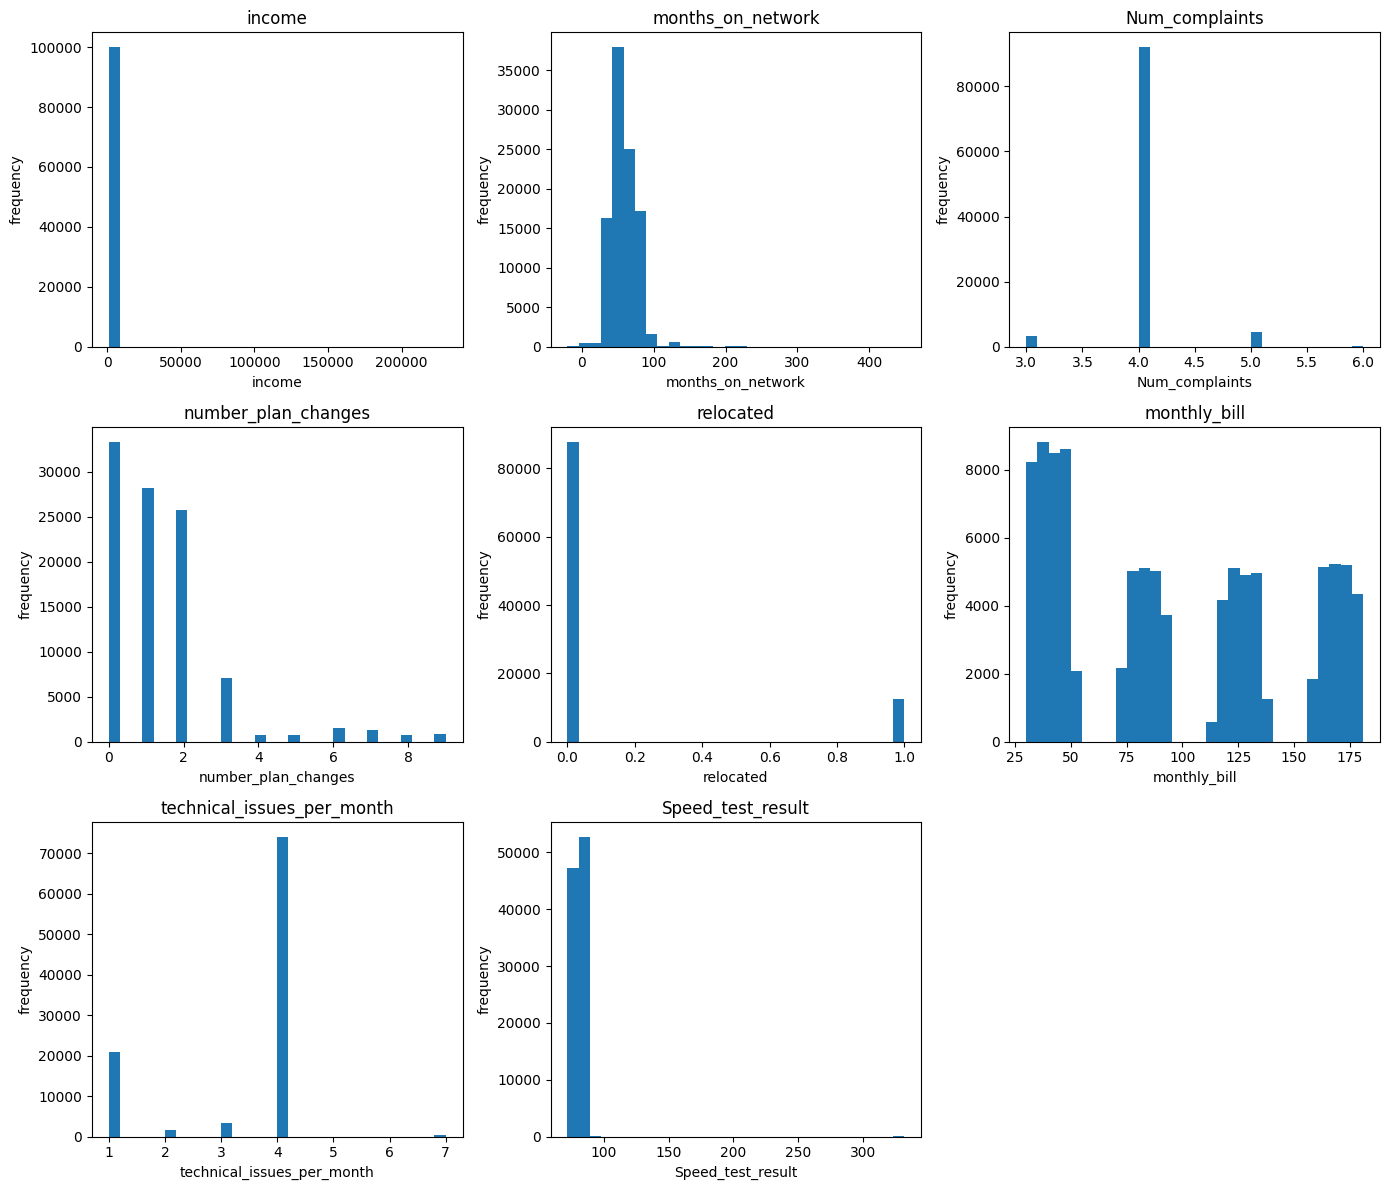

In [ ]:
# Cell 7 — Histograms for features
feature_cols = [c for c in df.columns if c != target_col]

n = len(feature_cols)
cols = 3
rows = int(np.ceil(n / cols))

plt.figure(figsize=(14, 4 * rows))
for i, col in enumerate(feature_cols, start=1):
    plt.subplot(rows, cols, i)
    plt.hist(df[col], bins=30)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("frequency")
plt.tight_layout()
plt.show()


## 4) Bivariate View: Feature vs Target

We compare feature distributions by `active_cust` using boxplots.


/tmp/ipython-input-1763428983.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=["0", "1"], showfliers=False)
/tmp/ipython-input-1763428983.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=["0", "1"], showfliers=False)
/tmp/ipython-input-1763428983.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=["0", "1"], showfliers=False)
/tmp/ipython-input-1763428983.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will

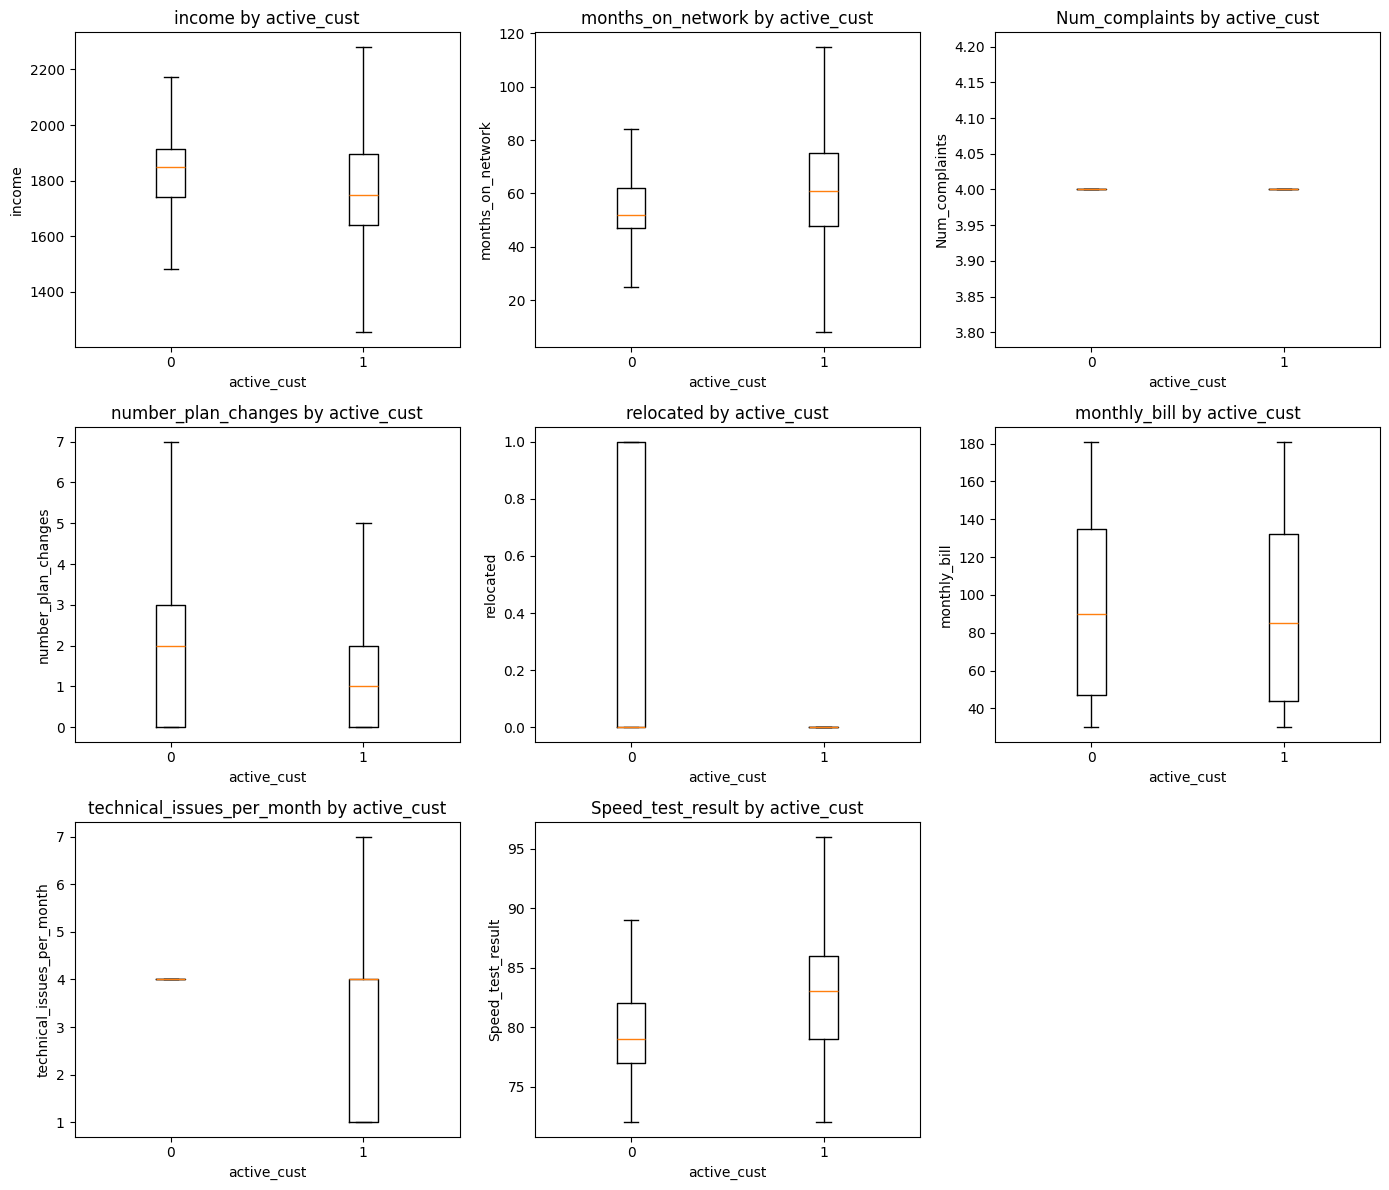

In [ ]:
# Cell 8 — Boxplots by target
rows = int(np.ceil(n / cols))

plt.figure(figsize=(14, 4 * rows))
for i, col in enumerate(feature_cols, start=1):
    plt.subplot(rows, cols, i)
    data0 = df[df[target_col] == 0][col]
    data1 = df[df[target_col] == 1][col]
    plt.boxplot([data0, data1], labels=["0", "1"], showfliers=False)
    plt.title(f"{col} by {target_col}")
    plt.xlabel(target_col)
    plt.ylabel(col)
plt.tight_layout()
plt.show()


## 5) Correlation Analysis

Since all columns are numeric in this dataset, we can inspect correlations and visualize them.


,active_cust,income,months_on_network,Num_complaints,number_plan_changes,relocated,monthly_bill,technical_issues_per_month,Speed_test_result
active_cust,1.000,0.001,0.188,-0.083,-0.283,-0.381,-0.060,-0.260,0.156
income,0.001,1.000,-0.123,0.003,-0.004,0.002,-0.005,-0.003,0.010
months_on_network,0.188,-0.123,1.000,-0.082,0.023,-0.045,0.008,-0.041,0.020
Num_complaints,-0.083,0.003,-0.082,1.000,0.074,0.054,0.005,0.020,0.004
number_plan_changes,-0.283,-0.004,0.023,0.074,1.000,0.596,0.025,0.180,-0.009
relocated,-0.381,0.002,-0.045,0.054,0.596,1.000,0.019,0.113,0.015
monthly_bill,-0.060,-0.005,0.008,0.005,0.025,0.019,1.000,0.127,-0.000
technical_issues_per_month,-0.260,-0.003,-0.041,0.020,0.180,0.113,0.127,1.000,-0.055
Speed_test_result,0.156,0.010,0.020,0.004,-0.009,0.015,-0.000,-0.055,1.000


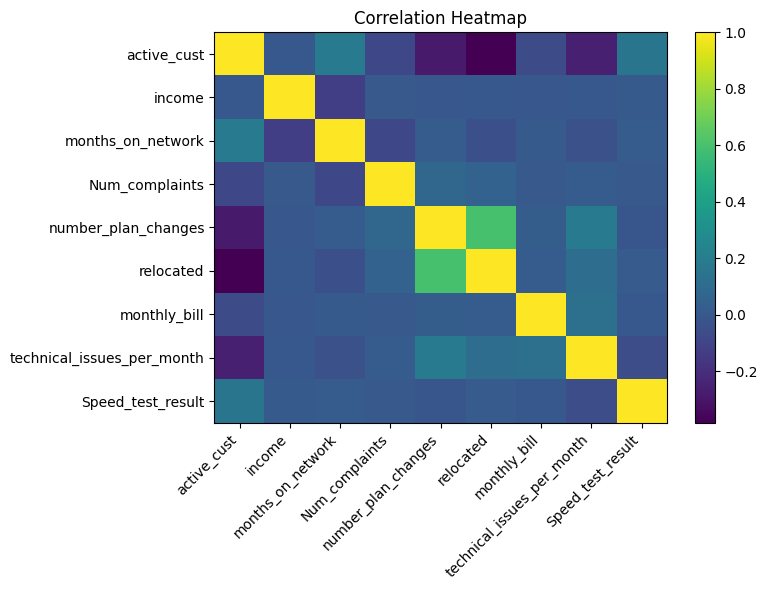

In [ ]:
# Cell 9 — Correlation matrix (numeric)
corr = df.corr(numeric_only=True)

display(corr.round(3))

plt.figure(figsize=(8,6))
plt.imshow(corr.values, aspect="auto")
plt.title("Correlation Heatmap")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.index)), corr.index)
plt.colorbar()
plt.tight_layout()
plt.show()


# 6) Modeling — Logistic Regression

### Why Logistic Regression?
- It is a strong baseline for binary classification
- Coefficients are interpretable (direction and magnitude after scaling)
- Works well when relationships are close to linear in log-odds

### Approach
1. Train/test split
2. Standardize features
3. Fit Logistic Regression
4. Evaluate with accuracy, precision, recall, F1, ROC-AUC, confusion matrix, ROC curve


In [ ]:
# Cell 10 — Train/test split
X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train target balance:", y_train.value_counts(normalize=True).round(3).to_dict())
print("Test  target balance:", y_test.value_counts(normalize=True).round(3).to_dict())


Train shape: (80000, 8) Test shape: (20000, 8)
Train target balance: {1: 0.579, 0: 0.421}
Test  target balance: {1: 0.579, 0: 0.421}


In [ ]:
# Cell 11 — Build pipeline (scaler + logistic regression)
# class_weight='balanced' helps when classes are not perfectly balanced.
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

pipe.fit(X_train, y_train)
print("Model trained.")


Model trained.


In [ ]:
# Cell 12 — Predictions & probability scores
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred, zero_division=0),
    "recall": recall_score(y_test, y_pred, zero_division=0),
    "f1": f1_score(y_test, y_pred, zero_division=0),
    "roc_auc": roc_auc_score(y_test, y_proba),
}

display(pd.DataFrame([metrics]).round(4))


,accuracy,precision,recall,f1,roc_auc
0,0.7533,0.8145,0.7428,0.777,0.8383


<Figure size 500x400 with 0 Axes>

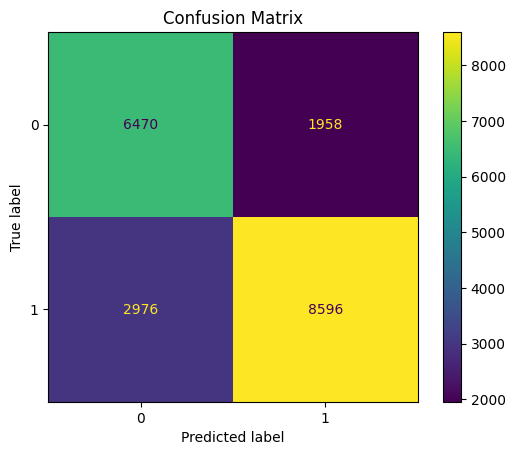

In [ ]:
# Cell 13 — Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

plt.figure(figsize=(5,4))
disp.plot(values_format="d")
plt.title("Confusion Matrix")
plt.show()


<Figure size 600x500 with 0 Axes>

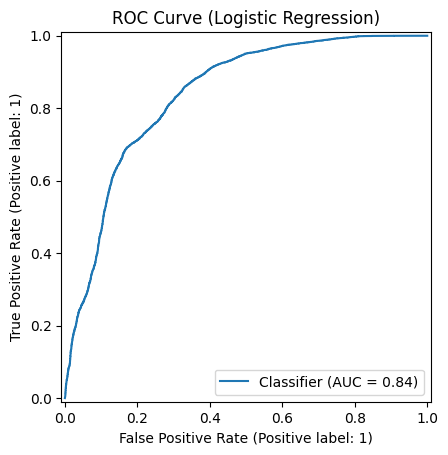

In [ ]:
# Cell 14 — ROC Curve
plt.figure(figsize=(6,5))
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve (Logistic Regression)")
plt.show()


## 7) Model Interpretation — Coefficients

Because we used standardization, coefficients are comparable in scale:
- **Positive coefficient** → higher feature value increases probability of `active_cust = 1`
- **Negative coefficient** → higher feature value decreases probability of `active_cust = 1`

We will list the strongest positive and negative drivers.


,feature,coef
0,relocated,-1.039704
1,technical_issues_per_month,-0.460971
2,number_plan_changes,-0.292598
3,Num_complaints,-0.193009
4,monthly_bill,-0.112274
5,months_on_network,0.515949
6,Speed_test_result,2.135656
7,income,4.669871


,feature,coef
7,income,4.669871
6,Speed_test_result,2.135656
5,months_on_network,0.515949
4,monthly_bill,-0.112274
3,Num_complaints,-0.193009
2,number_plan_changes,-0.292598
1,technical_issues_per_month,-0.460971
0,relocated,-1.039704


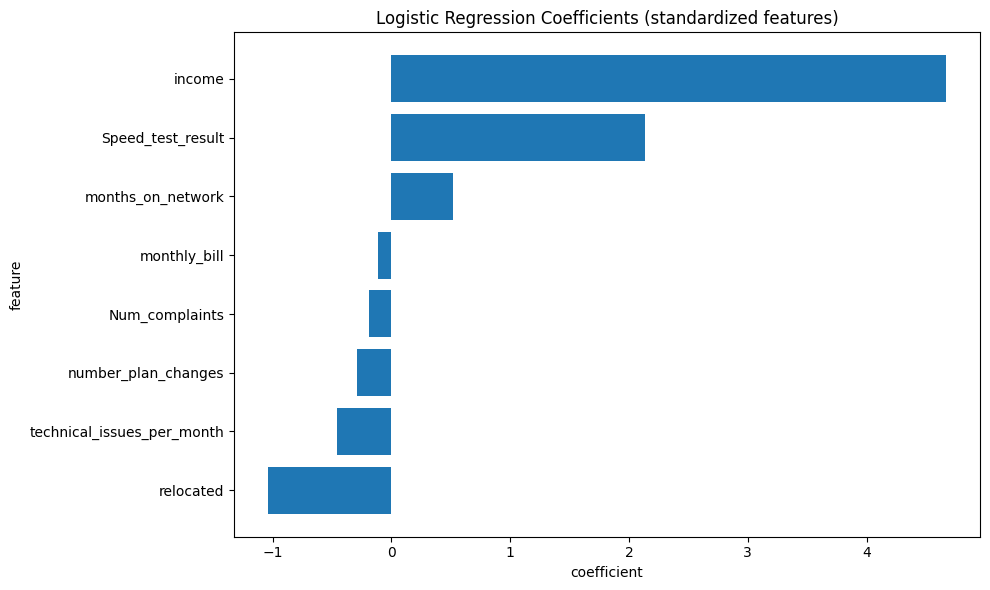

In [ ]:
# Cell 15 — Coefficient interpretation
lr = pipe.named_steps["model"]
coefs = pd.Series(lr.coef_[0], index=X.columns).sort_values()

display(pd.DataFrame({
    "feature": coefs.index,
    "coef": coefs.values
}).sort_values("coef").head(10))

display(pd.DataFrame({
    "feature": coefs.index,
    "coef": coefs.values
}).sort_values("coef", ascending=False).head(10))

# Visualize coefficients
plt.figure(figsize=(10,6))
coefs_sorted = coefs.sort_values()
plt.barh(coefs_sorted.index, coefs_sorted.values)
plt.title("Logistic Regression Coefficients (standardized features)")
plt.xlabel("coefficient")
plt.ylabel("feature")
plt.tight_layout()
plt.show()


# 8) Next Steps (Optional Enhancements)

If you want to push the model further:
- Try regularization tuning (`C`) with cross-validation
- Try tree-based models (RandomForest / XGBoost) for non-linear patterns
- Add interaction terms or polynomial features if the relationships are non-linear
- Calibrate probabilities if probability accuracy matters (e.g., `CalibratedClassifierCV`)
